# 1. Bayesian Image Reconstruction 

### Bahman Roostaei

The problem of retrieving patterns from noisy data including the reconstruction of images from augmented ones can be expressed as follows:


Consider an observed vector of data ${\bf b}$ assumed to be originally from data ${\bf x}$:

$$ {\bf b} = {\bf A}{\bf x} + {\bf \eta}$$

in which ${\bf A}$ is a matrix unknown and $\bf \eta$ a Gaussian noise:

$$ P({\bf\eta}) \propto \exp\left\{{-{1\over 2\sigma^2}\eta^T\eta}\right\}$$

The goal is to find $\bf x$ from the observation $\bf b$. In a Bayesian paradigm the goal is expressed as finding the probability distribution for $\bf x$ given $\bf b$:

$$ P({\bf x}|{\bf b}) \propto P({\bf b}| {\bf x})P({\bf x})$$

Using Monte Carlo (MC) method it is perhaps possible to sample from this probability with a proposed prior for ${\bf x}$ with a hope to obtained as much from the real data as possible. In the case of image we would like to find out the image that is close to the original image. The measure of success can be the convergence of the sampled vector or in other words steady state of the sampled vector after enough number of samplings.

There are several algorithms for samplings however we will limit ourselves here to few:

1. Markov Chain: At each MC step we update each configuration using the configuration obtained in the last step.

2. Random Walk (Markov Chain): Not only we update using the last obtained configuration, we also pick the site (vector element) based on the previous site picked.

3. Prior Selection:

    3.1. Ising model : $ P({\bf x}) \propto \exp\left\{-J\sum_{\langle ij\rangle} x_i x_j\right\}$. This prior expresses the assumption that the pixels close to each other tend to be of the same intensity. This, we will see that works very well for binary images.
    
    3.2. Multilevel model: $ P({\bf x})\propto \exp\left\{-J\sum_{\langle ij\rangle} \Theta(x_i - x_j)\right\}$ in which $\Theta(x)$ is a piecewise function. This model may work for grey scale images.
    
In the following we will use the Metropolis algorithm for our Monte Carlo reconstruction.
    


In [1]:
from skimage import data, img_as_float, color
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np

In [2]:
original = img_as_float(data.chelsea()[100:250, 50:300])

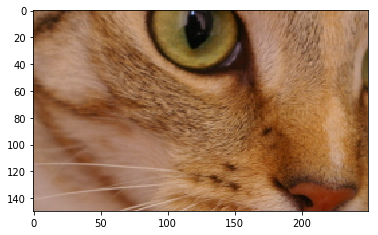

In [3]:
plt.imshow(original)
plt.show()

We can prepare some noisy image from an original one by adding some Gaussian noise however we try just the image itself knowing that this will work for small noise as well.

In [9]:
sigma = 0.0
noisy = random_noise(original, var=sigma**2)

and take only one layer:

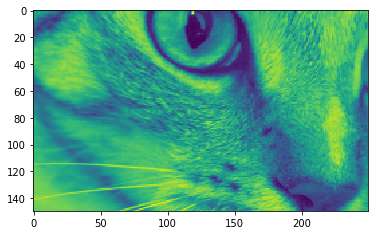

In [10]:
plt.imshow(noisy[:,:,1])
plt.show()

In [11]:
image = noisy[:,:,1]

We convert it to a binary image:

In [12]:
image_binary = 2*(np.ceil(image - 0.5) - 0.5)

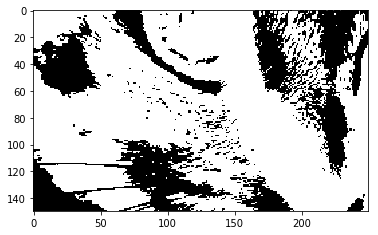

In [13]:
plt.imshow(image_binary,cmap='Greys')
plt.show()

We create a class to identify the nearest neighbor pixels and with periodic boundary condition:

In [14]:
class neighbor():
    
    def __init__(self,ix,iy,ix_max,iy_max):
             
        if ix < ix_max - 1:
            self.right = ix
        else:
            self.right = 0
        
        if ix > 0:
            self.left = ix - 1
        else:
            self.left = ix_max - 1
        
        if iy < iy_max - 1:
            self.up = iy + 1
        else:
            self.up = 0
        
        if iy > 0:
            self.down = iy - 1
        else:
            self.down = iy_max - 1

## Ising prior:

In [15]:
ix_max, iy_max = image_binary.shape

In [16]:
X = np.ones((ix_max,iy_max))

In [17]:
X.shape

(150, 250)

In [18]:
def ising_binary_reconstruct(current_image,image_binary,max_itr,J,tau=0.2,
                             random_walk=False,start_fresh=True):

    
    # initialize the image:
    ix_max, iy_max = image_binary.shape
    # start with previous runs or not:
    if start_fresh:
        X = np.ones((ix_max,iy_max))
    else:
        X = current_image
    ix = np.random.randint(low=0,high=ix_max)
    iy = np.random.randint(low=0,high=iy_max)
    diff = []
    itr = 0
    if random_walk:  
        while itr < max_itr:
            nb = neighbor(ix,iy,ix_max,iy_max)
            neighbor_sites = [(ix,nb.up),(ix,nb.down),(nb.left,iy),(nb.right,iy)]
            neighbor_thetas = [X[a[0],a[1]] for a in neighbor_sites]
            Xp = -X[ix,iy]
            like_ratio = np.exp(image_binary[ix,iy]*(Xp - X[ix,iy])/tau**2)
            d = [X[ix,iy] != t for t in neighbor_thetas]
            dp = [Xp != t for t in neighbor_thetas]
            ising_prior_ratio = np.exp(2*J*(sum(d)-sum(dp)))
            prop_ratio = like_ratio*ising_prior_ratio
            r = np.random.rand()
            if r < prop_ratio:
                X[ix,iy] = Xp
            if itr%100 == 0:
                dX = X - image_binary
                dX_flat = dX.flatten()
                diff.append(np.linalg.norm(dX_flat)/len(dX_flat))

            ix = np.random.choice([ix]+[a[0] for a in neighbor_sites])
            iy = np.random.choice([iy]+[a[1] for a in neighbor_sites])
            itr += 1
        return X,diff
    else:
        while itr < max_itr:
            ix = np.random.randint(low=0,high=ix_max)
            iy = np.random.randint(low=0,high=iy_max)
            nb = neighbor(ix,iy,ix_max,iy_max)
            neighbor_sites = [(ix,nb.up),(ix,nb.down),(nb.left,iy),(nb.right,iy)]
            neighbor_thetas = [X[a[0],a[1]] for a in neighbor_sites]
            Xp = -X[ix,iy]
            like_ratio = np.exp(image_binary[ix,iy]*(Xp - X[ix,iy])/tau**2)
            d = [X[ix,iy] != t for t in neighbor_thetas]
            dp = [Xp != t for t in neighbor_thetas]
            ising_prior_ratio = np.exp(2*J*(sum(d)-sum(dp)))
            prop_ratio = like_ratio*ising_prior_ratio
            r = np.random.rand()
            if r < prop_ratio:
                X[ix,iy] = Xp
            if itr%100 == 0:
                dX = X - image_binary
                dX_flat = dX.flatten()
                diff.append(np.linalg.norm(dX_flat)/len(dX_flat))
            itr += 1
        return X,diff

In [19]:
X,diff = ising_binary_reconstruct(X,image_binary=image_binary,max_itr=100000,J=0.5,tau=0.2,
                                  start_fresh=True,random_walk=False)

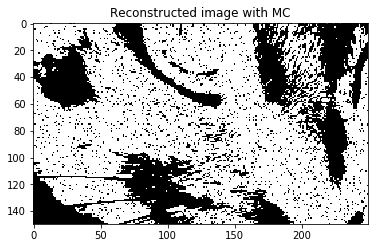

In [21]:
plt.imshow(X,cmap='Greys')
plt.title('Reconstructed image with MC')
plt.show()

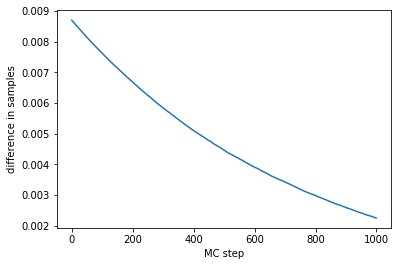

In [22]:
plt.plot(diff)
plt.xlabel('MC step')
plt.ylabel('difference in samples')
plt.show()

As we can see (the difference is averaged every 100 steps) MC sampling converges to the real binary image relatively fast with Ising prior.

## Multilevel Prior:

In [23]:
theta = np.ones(image_binary.shape)

In [27]:
def mlv_reconstruct(current_image,image,max_itr,J,tau=0.2,gap = 0.1,epsilon=1.0,
                             random_walk=False,start_fresh=True):

    
    # initialize the image:
    ix_max, iy_max = image_binary.shape
    if start_fresh:
        X = np.ones((ix_max,iy_max))
    else:
        X = current_image
    ix = np.random.randint(low=0,high=ix_max)
    iy = np.random.randint(low=0,high=iy_max)
    diff = []
    itr = 0
    if random_walk:  
        while itr < max_itr:
            nb = neighbor(ix,iy,ix_max,iy_max)
            neighbor_sites = [(ix,nb.up),(ix,nb.down),(nb.left,iy),(nb.right,iy)]
            neighbor_thetas = [X[a[0],a[1]] for a in neighbor_sites]
            delta_X = (np.random.rand() - 1)*epsilon
            Xp = X[ix,iy] + delta_X
            exponent = image[ix,iy]*(Xp - X[ix,iy])
            exponent += Xp**2 - X[ix,iy]**2
            like_ratio = np.exp(exponent/tau**2)
            d = [(X[ix,iy] - t) > gap for t in neighbor_thetas]
            dp = [(Xp - t) > gap for t in neighbor_thetas]
            ising_prior_ratio = np.exp(2*J*(sum(d)-sum(dp)))
            prop_ratio = like_ratio*ising_prior_ratio
            r = np.random.rand()
            if r < prop_ratio:
                X[ix,iy] = Xp
            if itr%100 == 0:
                dX = X - image_binary
                dX_flat = dX.flatten()
                diff.append(np.linalg.norm(dX_flat)/len(dX_flat))

            ix = np.random.choice([ix]+[a[0] for a in neighbor_sites])
            iy = np.random.choice([iy]+[a[1] for a in neighbor_sites])
            itr += 1
        return X,diff
    else:
        while itr < max_itr:
            ix = np.random.randint(low=0,high=ix_max)
            iy = np.random.randint(low=0,high=iy_max)
            nb = neighbor(ix,iy,ix_max,iy_max)
            neighbor_sites = [(ix,nb.up),(ix,nb.down),(nb.left,iy),(nb.right,iy)]
            neighbor_thetas = [X[a[0],a[1]] for a in neighbor_sites]
            delta_X = (np.random.rand() - 1)*epsilon
            Xp = X[ix,iy] + delta_X
            exponent = image[ix,iy]*(Xp - X[ix,iy])
            exponent += Xp**2 - X[ix,iy]**2
            like_ratio = np.exp(exponent/tau**2)
            d = [np.abs(X[ix,iy] - t) > gap for t in neighbor_thetas]
            dp = [np.abs(Xp - t) > gap for t in neighbor_thetas]
            ising_prior_ratio = np.exp(2*J*(sum(d)-sum(dp)))
            prop_ratio = like_ratio*ising_prior_ratio
            r = np.random.rand()
            if r < prop_ratio:
                X[ix,iy] = Xp
            if itr%100 == 0:
                dX = X - image_binary
                dX_flat = dX.flatten()
                diff.append(np.linalg.norm(dX_flat)/len(dX_flat))
            itr += 1
        return X,diff

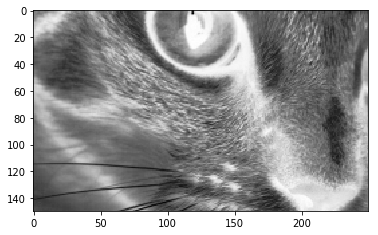

In [28]:
plt.imshow(image,cmap='Greys')
plt.show()

In [29]:
X,diff = mlv_reconstruct(X,image,max_itr=500000,J=0.5,tau=0.2,gap = .5,epsilon=1.0,
                             random_walk=False,start_fresh=True)

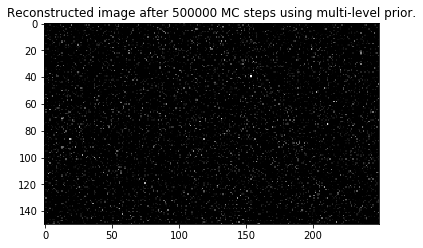

In [30]:
plt.imshow(X,cmap='Greys')
plt.title('Reconstructed image after 500000 MC steps using multi-level prior.')
plt.show()

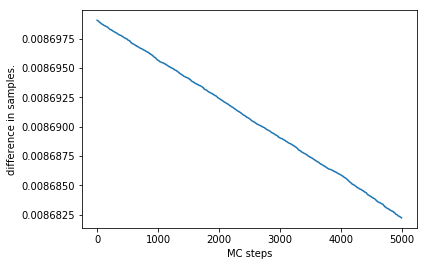

In [32]:
plt.plot(diff)
plt.xlabel('MC steps')
plt.ylabel('difference in samples.')
plt.show()

Although the multilevel prior (averaged every 100 steps.) seems to be pacing toward the correct image but the rate of convergence is slow. A full hyperparameter search may help to find a faster rate.

# 2. XY Model of Magnetization

Hamiltonian models are known in statistical physics to describe the probability of the observation of a particular state of matter. Any state, $S$ of matter posses an energy $U(S)$. According to Boltzman, probability of the observation of such state at temperature $T$ is:

$$ P(S) \propto \exp\left\{-{U(S)\over k_B T}\right\} $$

in which $k_B$ is a universal constant called the Boltzman constant. It is obvious that matter in equilibrium tends to descend into the state of lowest energy as much as temperature allows. 

Any observable of matter is also a function of the state of the matter $M(S)$. As the result at temperature $T$ the average of $M$ will be measured:

$$ E[M] = \sum_S M(S) P(S) $$.

Using the Metropolis algorithm of Monte Carlo method we intend to calculate the above average which is almost impossible using direct integration.

### XY Model:

XY model is a particular model of magnetism of two dimensional materials. Consider a square lattice (just like image pixels). On each site of the lattice there is a two dimensioanl vector (magnet) with unit magnitude. This vector can be identified by an angle $\theta_i$. The Hamiltonian model for the probability (likelihood) of such system is:

$$ U(\{\theta_1,\ldots\,\theta_N\}) = -J \sum_{\langle ij\rangle} \cos(\theta_i - \theta_j) - h\sum_i\cos(\theta_i)$$

This models the posterior for the prior for magnetic material. $J$ is a measure of how much the neighboring magnets tend to align with each other and $h$ is a measure of how much the magnets are forced to aligned with an external magnetic field. 

The total magnetizatio of this material is defined:

$$ M(\{\theta_1,\ldots,\theta_N\}) = {1\over N}\sum_{i=1}^N \cos(\theta_i)$$
For small values of $J/h$ the expectation is that the $E[M]$ will be close to +1 or -1 while for large values it should vanish.

We assume the system is defined on a square lattice with size ix_max = iy_max :

In [34]:
ix_max = 100
iy_max = 100

In the following MC estimation, we model each $\theta_i$ by diving the $2\pi$ into n_max number of equally spaced angles and limit the fluctuations into those angles. The rest of the code is almost the same as the image reconstruction except with an extra step: Each proposal step in the MC will be accepted if it lowers the energy ($\Delta U < 0 $) otherwise it still can be accepted with the probability defined by Botzman factor:

In [58]:
def XY_magnetization(theta,max_itr,J,h,n_max=10,size=(ix_max,iy_max),
                     compute_average=False,start_fresh=False):
    # diving the 2pi :
    angles = [2*np.pi*i/n_max for i in range(n_max)]
    if start_fresh:
        theta = np.random.choice(angles,size=size)
    itr = 0
    ix = np.random.randint(low=0,high=ix_max)
    iy = np.random.randint(low=0,high=iy_max)
    diff = []
    mag = 0
    mag_track = []
    while itr < max_itr:
        ix = np.random.randint(low=0,high=ix_max)
        iy = np.random.randint(low=0,high=iy_max)
        nb = neighbor(ix,iy,ix_max,iy_max)
        neighbor_sites = [(ix,nb.up),(ix,nb.down),(nb.left,iy),(nb.right,iy)]
        neighbor_thetas = [theta[a[0],a[1]] for a in neighbor_sites]
        d_theta = np.random.choice(angles)
        #d_theta = np.random.choice([2*np.pi/n_max,2*np.pi*(1-1/n_max)])
        thetap = theta[ix,iy] + d_theta
        d = [np.cos(theta[ix,iy] - t) for t in neighbor_thetas]
        dp = [np.cos(thetap - t) for t in neighbor_thetas]
        d_energy = J*(sum(d)-sum(dp)) - h*np.cos(theta[ix,iy]) + h*np.cos(thetap)
        if itr%100 == 0:
            dt = np.cos(theta[ix,iy]) - np.cos(thetap)
            diff.append(dt)
        if d_energy < 0:
            theta[ix,iy] = thetap
        else:
            r = np.random.rand()
            prior_ratio = np.exp(-d_energy)
            if r < prior_ratio:
                theta[ix,iy] = thetap
        if compute_average:
            inst_mag = np.mean(np.cos(theta))
            mag_track.append(inst_mag)
            mag += inst_mag/max_itr
            
        itr += 1
    return theta,diff,mag_track,mag

We run the MC for $J=0$ much larger than $h=0$:

In [65]:
theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=20000,J=0,h=0.,n_max=20,
                                  compute_average=True,start_fresh=True)

Here we illustrate the angles by unit vectors:

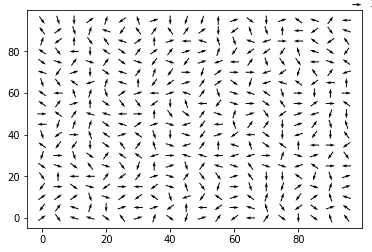

In [66]:
X, Y = np.meshgrid(np.arange(0,100), np.arange(0,100))

U = np.cos(theta)
V = np.sin(theta)

plt.figure()
plt.title('')
Q = plt.quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5],
               pivot='mid', units='inches')
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.show();

Let's look at the change in mean of the angles in MC steps:

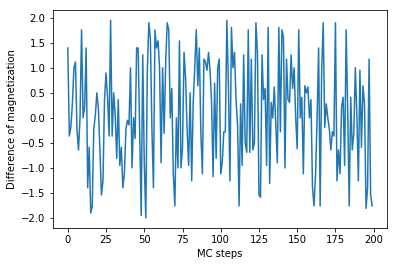

In [67]:
plt.plot(diff)
plt.xlabel('MC steps')
plt.ylabel('Difference of magnetization')
plt.show()

The above indicates a highly fluctuating smaple set which means the average of the moments (angles) is going to be zero. We can see this in the histogram below:

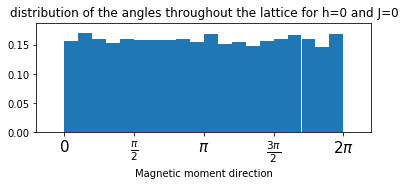

In [68]:
labels = ['0', '$\\frac{\pi}{2}$', '$\\pi$','$\\frac{3\pi}{2}$', '2$\pi$']

t_dist = [a%(2*np.pi) for a in theta.flatten()]
plt.hist(t_dist,bins=20,normed=True)
plt.xticks([0.,np.pi/2.0,np.pi,3*np.pi/2.0,2*np.pi], labels,fontsize=15)


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=.5)

plt.xlabel('Magnetic moment direction')
plt.title('distribution of the angles throughout the lattice for h=0 and J=0')
plt.show()

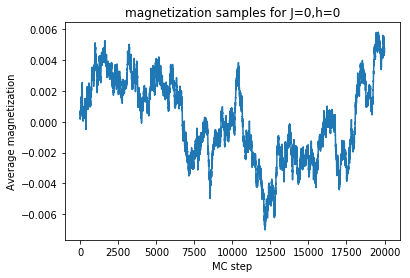

In [69]:
plt.plot(mag_track)
plt.xlabel('MC step')
plt.ylabel('Average magnetization')
plt.title('magnetization samples for J=0,h=0')
plt.show()

Let's try $J = .1$ and $h=0$:

In [70]:
theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=20000,J=.1,h=0,n_max=20,
                                  compute_average=True,start_fresh=True)

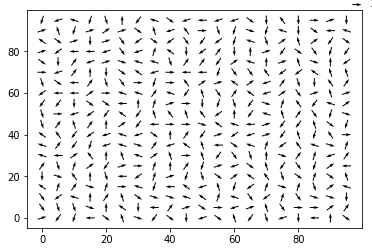

In [71]:
X, Y = np.meshgrid(np.arange(0,100), np.arange(0,100))

U = np.cos(theta)
V = np.sin(theta)

plt.figure()
plt.title('')
Q = plt.quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5],
               pivot='mid', units='inches')
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.show();

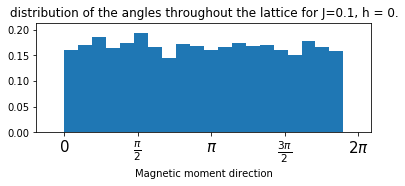

In [73]:
labels = ['0', '$\\frac{\pi}{2}$', '$\\pi$','$\\frac{3\pi}{2}$', '2$\pi$']

t_dist = [a%(2*np.pi) for a in theta.flatten()]
plt.hist(t_dist,bins=20,normed=True)
plt.xticks([0.,np.pi/2.0,np.pi,3*np.pi/2.0,2*np.pi], labels,fontsize=15)


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=.5)

plt.xlabel('Magnetic moment direction')
plt.title('distribution of the angles throughout the lattice for J=0.1, h = 0.')
plt.show()

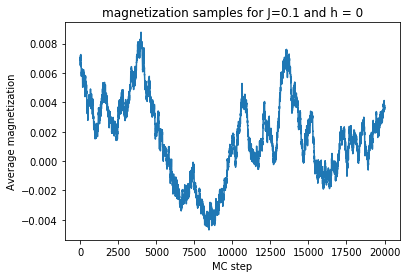

In [74]:
plt.plot(mag_track)
plt.xlabel('MC step')
plt.ylabel('Average magnetization')
plt.title('magnetization samples for J=0.1 and h = 0')
plt.show()

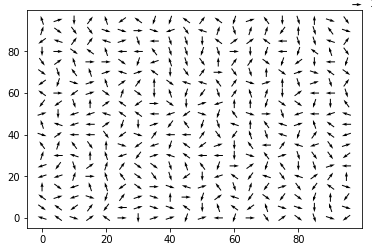

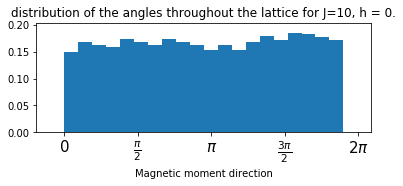

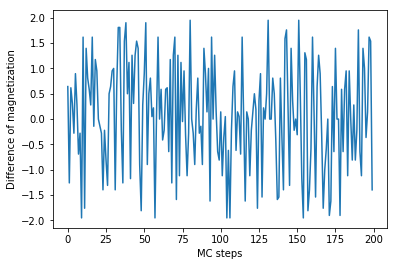

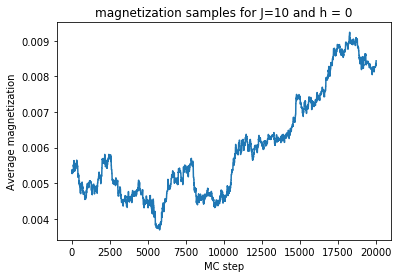

In [79]:
theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=20000,J=10,h=0,n_max=20,
                                  compute_average=True,start_fresh=False)

X, Y = np.meshgrid(np.arange(0,100), np.arange(0,100))

U = np.cos(theta)
V = np.sin(theta)

plt.figure()
plt.title('')
Q = plt.quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5],
               pivot='mid', units='inches')
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.show();


t_dist = [a%(2*np.pi) for a in theta.flatten()]
plt.hist(t_dist,bins=20,normed=True)
plt.xticks([0.,np.pi/2.0,np.pi,3*np.pi/2.0,2*np.pi], labels,fontsize=15)


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=.5)

plt.xlabel('Magnetic moment direction')
plt.title('distribution of the angles throughout the lattice for J=10, h = 0.')
plt.show();

plt.plot(diff)
plt.xlabel('MC steps')
plt.ylabel('Difference of magnetization')
plt.show();

plt.plot(mag_track)
plt.xlabel('MC step')
plt.ylabel('Average magnetization')
plt.title('magnetization samples for J=10 and h = 0')
plt.show()


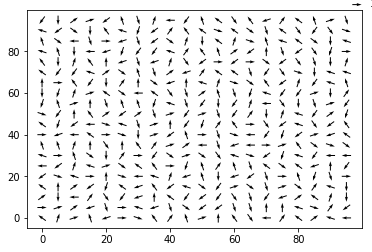

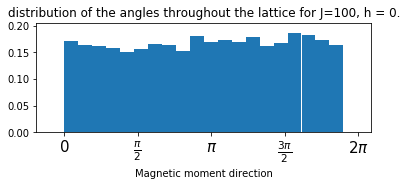

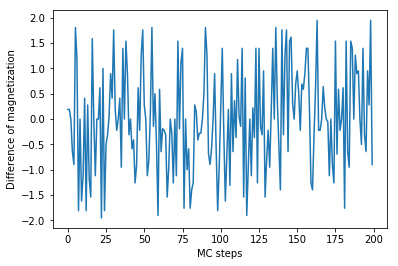

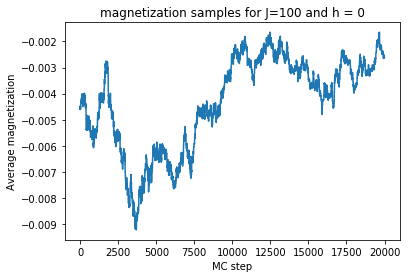

In [86]:
theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=20000,J=100,h=0,n_max=20,
                                  compute_average=True,start_fresh=True)

X, Y = np.meshgrid(np.arange(0,100), np.arange(0,100))

U = np.cos(theta)
V = np.sin(theta)

plt.figure()
plt.title('')
Q = plt.quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5],
               pivot='mid', units='inches')
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.show();


t_dist = [a%(2*np.pi) for a in theta.flatten()]
plt.hist(t_dist,bins=20,normed=True)
plt.xticks([0.,np.pi/2.0,np.pi,3*np.pi/2.0,2*np.pi], labels,fontsize=15)


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=.5)

plt.xlabel('Magnetic moment direction')
plt.title('distribution of the angles throughout the lattice for J=100, h = 0.')
plt.show();

plt.plot(diff)
plt.xlabel('MC steps')
plt.ylabel('Difference of magnetization')
plt.show();

plt.plot(mag_track)
plt.xlabel('MC step')
plt.ylabel('Average magnetization')
plt.title('magnetization samples for J=100 and h = 0')
plt.show()


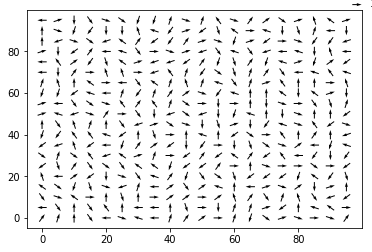

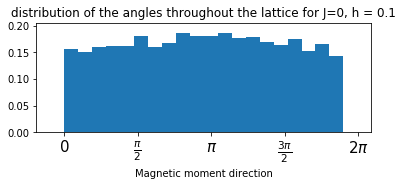

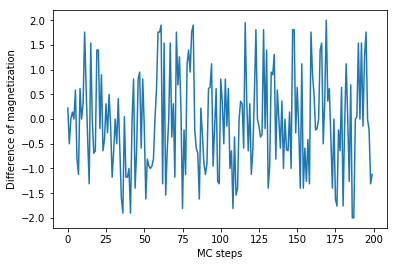

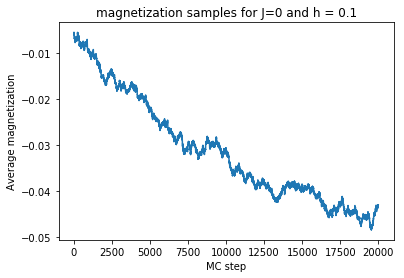

In [88]:
theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=20000,J=0,h=0.1,n_max=20,
                                  compute_average=True,start_fresh=True)

X, Y = np.meshgrid(np.arange(0,100), np.arange(0,100))

U = np.cos(theta)
V = np.sin(theta)

plt.figure()
plt.title('')
Q = plt.quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5],
               pivot='mid', units='inches')
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.show();


t_dist = [a%(2*np.pi) for a in theta.flatten()]
plt.hist(t_dist,bins=20,normed=True)
plt.xticks([0.,np.pi/2.0,np.pi,3*np.pi/2.0,2*np.pi], labels,fontsize=15)


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=.5)

plt.xlabel('Magnetic moment direction')
plt.title('distribution of the angles throughout the lattice for J=0, h = 0.1')
plt.show();

plt.plot(diff)
plt.xlabel('MC steps')
plt.ylabel('Difference of magnetization')
plt.show();

plt.plot(mag_track)
plt.xlabel('MC step')
plt.ylabel('Average magnetization')
plt.title('magnetization samples for J=0 and h = 0.1')
plt.show()


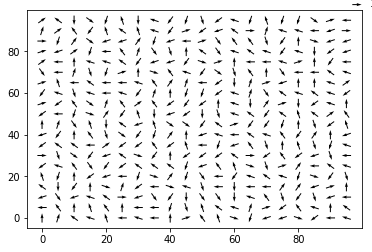

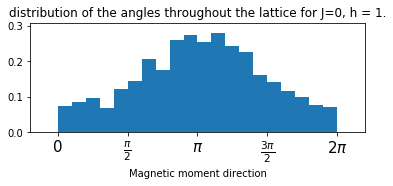

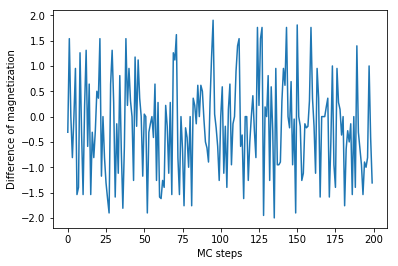

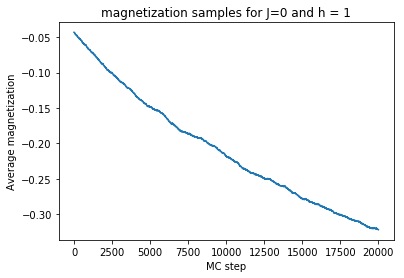

In [89]:
theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=20000,J=0,h=1,n_max=20,
                                  compute_average=True,start_fresh=False)

X, Y = np.meshgrid(np.arange(0,100), np.arange(0,100))

U = np.cos(theta)
V = np.sin(theta)

plt.figure()
plt.title('')
Q = plt.quiver(X[::5, ::5], Y[::5, ::5], U[::5, ::5], V[::5, ::5],
               pivot='mid', units='inches')
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.show();


t_dist = [a%(2*np.pi) for a in theta.flatten()]
plt.hist(t_dist,bins=20,normed=True)
plt.xticks([0.,np.pi/2.0,np.pi,3*np.pi/2.0,2*np.pi], labels,fontsize=15)


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=.5)

plt.xlabel('Magnetic moment direction')
plt.title('distribution of the angles throughout the lattice for J=0, h = 1.')
plt.show();

plt.plot(diff)
plt.xlabel('MC steps')
plt.ylabel('Difference of magnetization')
plt.show();

plt.plot(mag_track)
plt.xlabel('MC step')
plt.ylabel('Average magnetization')
plt.title('magnetization samples for J=0 and h = 1')
plt.show()


Obviously the magnetization has an average direction.

Now we perform the above MC for a series of values for $J/h$ and plot the magnetization average:

In [52]:
mag_average = []
for ratio in np.linspace(0.01,10.,20):
    # For burn in time:
    theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=10000,J=1,h=1/ratio,n_max=20,
                                  compute_average=False,start_fresh=True)
    theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=20000,J=1,h=1/ratio,n_max=20,
                                  compute_average=True,start_fresh=False)

    mag_average.append(mag)

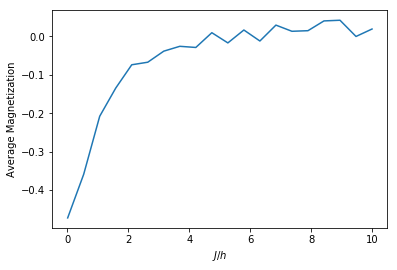

In [53]:
plt.plot(np.linspace(0.01,10.,20),mag_average)
plt.xlabel('$J / h$')
plt.ylabel('Average Magnetization')
plt.show()

In [92]:
mag_average = []
for J in np.linspace(0.0,100.,50):
    # For burn in time:
    theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=10000,J=J,h=0,n_max=20,
                                  compute_average=False,start_fresh=True)
    theta,diff,mag_track,mag = XY_magnetization(theta,max_itr=20000,J=J,h=0,n_max=20,
                                  compute_average=True,start_fresh=False)

    mag_average.append(mag)

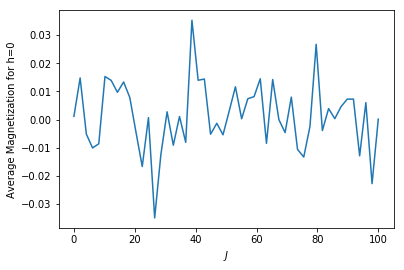

In [93]:
plt.plot(np.linspace(0.0,100.,50),mag_average)
plt.xlabel('$J$')
plt.ylabel('Average Magnetization for h=0')
plt.show()